In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sl3

#Load Data From Database

In [2]:
dbfile = "../recipes.db"
conn = sl3.connect(dbfile)
cur = conn.cursor()

In [3]:
# Take a peek at the existing tables
cur.execute("SELECT name, sql FROM sqlite_master WHERE type='table'")
for table, sql in cur.fetchall():
    print table, sql

recipes CREATE TABLE recipes(
		recipe_id INTEGER, 
		search_query TEXT,
		url TEXT,
		website TEXT,
		timestamp TEXT,
		average_rating REAL,
		number_ratings INTEGER,
		yield_quantity REAL,
		yield_units TEXT,
		yield_type TEXT,
		PRIMARY KEY (recipe_id,url)
		)
ingredients CREATE TABLE ingredients(
		recipe_id INTEGER,
                ingredient_id INTEGER,
		description TEXT,
		amount REAL
		)
new_ingredients CREATE TABLE "new_ingredients" (
"index" INTEGER,
  "recipe_id" REAL,
  "description" TEXT,
  "amount" REAL,
  "new_description" TEXT,
  "proportion" REAL
)
base_ingredients CREATE TABLE "base_ingredients" (
"index" INTEGER,
  "new_description" TEXT,
  "mean_proportion" REAL,
  "stddev_proportion" REAL,
  "counts" INTEGER
)


In [4]:
# Read in 'ingredients' table
query = "SELECT new_description, mean_proportion, stddev_proportion, counts FROM base_ingredients"
ingr_df = pd.read_sql(query, conn)

# Take a look at the data:
print len(ingr_df), 'entries'
print len(ingr_df.new_description.unique()), 'distinct ingredients'
print ingr_df.sort(['counts'],ascending=[0])[:20]

129 entries
129 distinct ingredients
    new_description  mean_proportion  stddev_proportion  counts
55           garlic         0.010577           0.007612      82
54   garbonzo beans         0.598739           0.186017      76
81        olive oil         0.043827           0.046208      69
67      lemon juice         0.076270           0.056109      67
102            salt         0.004098           0.003616      58
113          tahini         0.082664           0.065108      49
42            cumin         0.003360           0.003073      37
16     black pepper         0.001551           0.002348      28
122           water         0.138366           0.181471      22
87          paprika         0.001801           0.001171      17
25   cayenne pepper         0.002782           0.003351      16
11            basil         0.014749           0.022653      15
83            onion         0.097915           0.080114      15
14      bell pepper         0.134821           0.057082      14
63 

# Plot The Data

The goal here is to look at a few features of the data to see if we can find good criteria for distinguishing ingredients into different groups. Specifically, I'm looking at the mean & standard deviation of the proportion of each ingredient in it's respective recipe and the number of occurances of each ingredient within our recipe set.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
# create arrays for plotting inputs
mean = ingr_df['mean_proportion'].as_matrix()
stddev = ingr_df['stddev_proportion'].as_matrix()
counts = ingr_df['counts'].as_matrix()
samples = len(ingr_df)

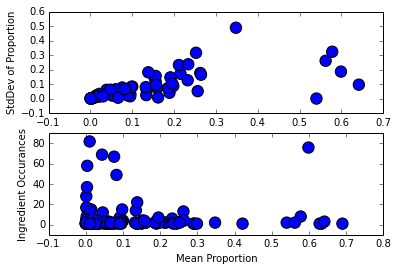

In [7]:
# first plot 2D distributions
plt.figure(1)
plt.subplot(211)
plt.scatter(mean,stddev,s=samples)
plt.ylabel('StdDev of Proportion')

plt.subplot(212)
plt.scatter(mean,counts,s=samples)
plt.ylabel('Ingredient Occurances')
plt.xlabel('Mean Proportion')

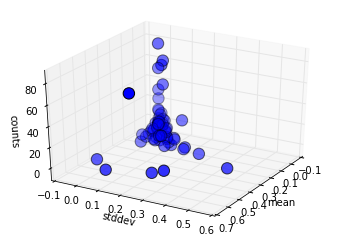

In [8]:
# Now generate interactive 3D plot with all features
from mpl_toolkits import mplot3d
from IPython.html.widgets import interact

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(mean, stddev, counts, s=samples)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('mean')
    ax.set_ylabel('stddev')
    ax.set_zlabel('counts')
    
interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

#Initial Thoughts:
I was thinking that that there might be more clear clusters of ingredients. My thinking was specifically in regard to porportion: If you think about, say, garbanzo beans and black beans in normal and black bean hummus respectively. You would expect them to have a porportion of their recipe. Nievely extrapolating this thinking, I figured you might be able to define clusters of ingredients that would result in a certain "type" of ingredient in a recipe and then use these clusters to select ingredients.

As I said though, it seems like there aren't quite as many separate distinct clusters as I expected. Especially when you look in the 3 dimensional space.

Never the less, I'll try just plugging the data in to a clustering algorithm.

#Apply Clustering to the Data
I chose the MeanShift algorithm which doesn't require a known number of clusters (but will determine this on it's own) and seems adequite for our relatively small dataset.

# Clustering(mean_proportion,stddev_proportion,raw counts)

In [9]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [10]:
X = ingr_df.as_matrix(['mean_proportion','stddev_proportion','counts'])
# turn all Nan's in to 0 (there are some in the stddev column)
X[np.invert(np.isfinite(X))] = 0

# automatically calculate bandwith for input to meanshift model
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=samples)

# create and run model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# get results
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

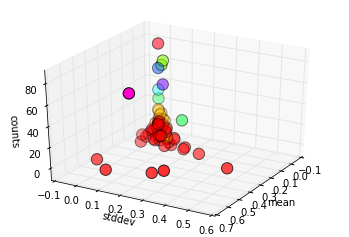

In [11]:
#plot 3d distribution again now with cluster labels shown in color
def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(mean, stddev, counts, c=labels,cmap='hsv', s=samples)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('mean')
    ax.set_ylabel('stddev')
    ax.set_zlabel('counts')
    
interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

In [12]:
# Print meanshift results
print("number of estimated labels : %d" % n_clusters_)

for i in range(n_clusters_):
    print 'Label %d was assigned to %d ingredients and has center:'%(i,len(labels[labels==i]))
    print '   mean:%f stddev:%f count:%f'%(cluster_centers[i,0],cluster_centers[i,1],cluster_centers[i,2])
    print '   It includes the following ingredients:'
    for index in np.where(labels==i)[0]:
        print '      %d %s'%(ingr_df['counts'][index],ingr_df['new_description'][index])
    print

number of estimated labels : 9
Label 0 was assigned to 112 ingredients and has center:
   mean:0.115295 stddev:0.035751 count:1.859813
   It includes the following ingredients:
      4 Italian dressing
      2 allspice
      1 apple sauce
      2 apples
      3 artichoke hearts
      1 arugula
      3 avocado
      1 bacon
      1 baking soda
      3 balsamic vinegar
      2 banana peppers
      1 bay leaf
      1 beets
      8 black beans
      6 bread
      1 broccoli
      1 broth
      1 brown sugar
      1 butter
      1 cabbage
      2 canola oil
      1 cashews
      1 celery seed
      1 cheddar cheese
      2 chicken breast
      2 chili powder
      1 chipotle pepper
      8 cilantro
      2 cinnamon
      1 coconut
      1 cocounut oil
      1 coleslaw
      3 coriander
      2 corn
      2 cottage cheese
      2 cream cheese
      2 crushed red pepper
      4 cucumber
      1 curry paste
      3 curry powder
      1 dijon mustard
      1 dill
      1 egg
      1 eggplant
  

#Thoughts on first results:
The clusters were not quite what I expected, but they seem compelling none the less. It seems that the resulting clusters were mostly driven by what I deem the most common and important ingredients. But the lower label numbers are interesting. It seems that label 0 clustered the most exotic and least used ingredients. And label 1 has some borderline ingredients: things that are solid optional ingredients (possibly good for making some recipe variants?). Then as far as I can tell labels 2-8 are essential core ingredients.

So while I expected to cluster similar types of ingredients, then choose the top "best" or most common ingredients from each type, instead the clusters seem to have effectively done the ingredient choosing for us. As described, I think a reasonable first pass for chosing ingredients would be to use labels 2-8 as an ingredient base and use label 1 for optional variants then discard label 0 ingredients.

EDIT: UPON CLOSER INSPECTION, IT SEEMS THAT THE CLUSTER GROUPINGS ARE DOMINATED BY COUNT. I'LL TRY NORMALIZING THE COUNTS VALUES AND RUNNING THE CLUSTERING AGAIN.

# Clustering(mean_proportion, stddev_proportion, norm_counts)

In [13]:
#create normalized counts column
ingr_df['norm_counts'] = ingr_df['counts']/ingr_df['counts'].max()
norm_counts = ingr_df['norm_counts'].as_matrix()

In [14]:
X_norm = ingr_df.as_matrix(['mean_proportion','stddev_proportion','norm_counts'])
X_norm[np.invert(np.isfinite(X_norm))] = 0

# automatically calculate bandwith for input to meanshift model
bandwidth_norm = estimate_bandwidth(X_norm, quantile=0.2, n_samples=samples)

# create and run model
ms_norm = MeanShift(bandwidth=bandwidth_norm, bin_seeding=True)
ms_norm.fit(X_norm)

# get results
labels_norm = ms_norm.labels_
cluster_centers_norm = ms_norm.cluster_centers_

labels_unique_norm = np.unique(labels_norm)
n_clusters_norm_ = len(labels_unique_norm)

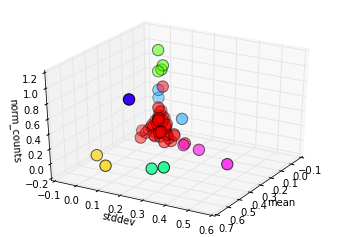

In [15]:
#plot 3d distribution again now with cluster labels shown in color

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(mean, stddev, norm_counts, c=labels_norm,cmap='hsv', s=samples)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('mean')
    ax.set_ylabel('stddev')
    ax.set_zlabel('norm_counts')
    
interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

In [16]:
# Print meanshift results
print("number of estimated labels : %d" % n_clusters_norm_)

for i in range(n_clusters_norm_):
    print 'Label %d was assigned to %d ingredients and has center:'%(i,len(labels_norm[labels_norm==i]))
    print '   mean:%f stddev:%f count:%f'%(cluster_centers_norm[i,0],cluster_centers_norm[i,1],cluster_centers_norm[i,2])
    print '   It includes the following ingredients:'
    for index in np.where(labels_norm==i)[0]:
        print '      %d %s'%(ingr_df['counts'][index],ingr_df['new_description'][index])
    print

number of estimated labels : 8
Label 0 was assigned to 109 ingredients and has center:
   mean:0.041754 stddev:0.011860 count:0.027182
   It includes the following ingredients:
      4 Italian dressing
      2 allspice
      1 apple sauce
      2 apples
      3 artichoke hearts
      1 arugula
      3 avocado
      1 bacon
      1 baking soda
      3 balsamic vinegar
      2 banana peppers
      15 basil
      1 bay leaf
      14 bell pepper
      6 bread
      1 broccoli
      1 broth
      1 brown sugar
      1 butter
      1 cabbage
      2 canola oil
      1 cashews
      16 cayenne pepper
      1 celery seed
      1 cheddar cheese
      2 chicken breast
      2 chili powder
      1 chipotle pepper
      8 cilantro
      2 cinnamon
      1 coconut
      1 cocounut oil
      1 coleslaw
      3 coriander
      2 cottage cheese
      2 cream cheese
      2 crushed red pepper
      4 cucumber
      1 curry paste
      3 curry powder
      1 dijon mustard
      1 dill
      1 egg
      

# Thoughts After Normalizing Counts
It's clear that normalization made a big differance and that the un-normalized counts were dominating the clustering. The new 3D results, with normalized counts, don't seem quite as useful by eye. It seems that maybe the standard deviation is not in fact that useful of a feature. I'll try variations of reducing dimensions and see how the clusters change

# Clustering(mean_proportion, raw counts)

In [17]:
X_2d = ingr_df.as_matrix(['mean_proportion', 'norm_counts'])
X_2d[np.invert(np.isfinite(X_2d))] = 0

# automatically calculate bandwith for input to meanshift model
bandwidth_2d = estimate_bandwidth(X_2d, quantile=0.2, n_samples=samples)

# create and run model
ms_2d = MeanShift(bandwidth=bandwidth_2d, bin_seeding=True)
ms_2d.fit(X_2d)

# get results
labels_2d = ms_2d.labels_
cluster_centers_2d = ms_2d.cluster_centers_

labels_unique_2d = np.unique(labels_2d)
n_clusters_2d_ = len(labels_unique_2d)

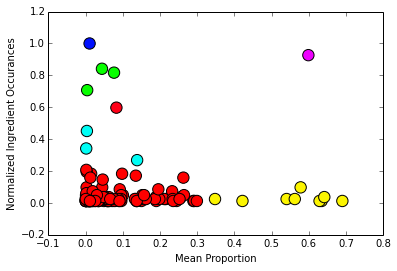

In [18]:
#plot distribution with color cluster labels

plt.scatter(mean,norm_counts,c=labels_2d,cmap='hsv',s=samples)
plt.ylabel('Normalized Ingredient Occurances')
plt.xlabel('Mean Proportion')

In [19]:
# Print meanshift results
print("number of estimated labels : %d" % n_clusters_2d_)

for i in range(n_clusters_2d_):
    print 'Label %d was assigned to %d ingredients and has center:'%(i,len(labels_2d[labels_2d==i]))
    print '   mean:%f count:%f'%(cluster_centers_2d[i,0],cluster_centers_2d[i,1])
    print '   It includes the following ingredients:'
    for index in np.where(labels_2d==i)[0]:
        print '      %d %s'%(ingr_df['counts'][index],ingr_df['new_description'][index])
    print

number of estimated labels : 7
Label 0 was assigned to 111 ingredients and has center:
   mean:0.047388 count:0.024821
   It includes the following ingredients:
      4 Italian dressing
      2 allspice
      1 apple sauce
      2 apples
      3 artichoke hearts
      1 arugula
      3 avocado
      1 bacon
      1 baking soda
      3 balsamic vinegar
      2 banana peppers
      15 basil
      1 bay leaf
      14 bell pepper
      6 bread
      1 broccoli
      1 broth
      1 brown sugar
      1 butter
      1 cabbage
      2 canola oil
      1 cashews
      16 cayenne pepper
      1 celery seed
      1 cheddar cheese
      2 chicken breast
      2 chili powder
      1 chipotle pepper
      8 cilantro
      2 cinnamon
      1 coconut
      1 cocounut oil
      1 coleslaw
      3 coriander
      2 cottage cheese
      2 cream cheese
      2 crushed red pepper
      4 cucumber
      1 curry paste
      3 curry powder
      1 dijon mustard
      1 dill
      1 egg
      1 fennel seed
  

# Thoughts on 2d Results
losing stddev seems to have helped but the 2d clusters still don't seem very intuitively useful. To reproduce the first cluster results I got (which seemed the most useful), I'll resort to 1D clustering just with repsect to counts (i.e. number of occurances of an ingredient in different recipes)

#Clustering(norm_counts)

In [20]:
X_1d = ingr_df.as_matrix(['counts'])
X_1d[np.invert(np.isfinite(X_1d))] = 0

# automatically calculate bandwith for input to meanshift model
bandwidth_1d = estimate_bandwidth(X_1d, quantile=0.2, n_samples=samples)

# create and run model
ms_1d = MeanShift(bandwidth=bandwidth_1d, bin_seeding=True)
ms_1d.fit(X_1d)

# get results
labels_1d = ms_1d.labels_
cluster_centers_1d = ms_1d.cluster_centers_

labels_unique_1d = np.unique(labels_1d)
n_clusters_1d_ = len(labels_unique_1d)

In [21]:
# Print meanshift results
print("number of estimated labels : %d" % n_clusters_1d_)

for i in range(n_clusters_1d_):
    print 'Label %d was assigned to %d ingredients and has center: %.2f counts'%(i,len(labels_1d[labels_1d==i]),cluster_centers_1d[i,0])
    print '   It includes the following ingredients:'
    print '  count: description:'
    for index in np.where(labels_1d==i)[0]:
        print '      %d %s'%(ingr_df['counts'][index],ingr_df['new_description'][index])
    print

number of estimated labels : 9
Label 0 was assigned to 112 ingredients and has center: 1.86 counts
   It includes the following ingredients:
  count: description:
      4 Italian dressing
      2 allspice
      1 apple sauce
      2 apples
      3 artichoke hearts
      1 arugula
      3 avocado
      1 bacon
      1 baking soda
      3 balsamic vinegar
      2 banana peppers
      1 bay leaf
      1 beets
      8 black beans
      6 bread
      1 broccoli
      1 broth
      1 brown sugar
      1 butter
      1 cabbage
      2 canola oil
      1 cashews
      1 celery seed
      1 cheddar cheese
      2 chicken breast
      2 chili powder
      1 chipotle pepper
      8 cilantro
      2 cinnamon
      1 coconut
      1 cocounut oil
      1 coleslaw
      3 coriander
      2 corn
      2 cottage cheese
      2 cream cheese
      2 crushed red pepper
      4 cucumber
      1 curry paste
      3 curry powder
      1 dijon mustard
      1 dill
      1 egg
      1 eggplant
      1 fennel s

# Conclusions

In the end, it seems simply the occurance of an ingredient was the best judge of building ingredient selection criteria. The cluster seems to have been effective at choosing 1 cluster that will be discarded (cluster 0), 1 cluster that will be only partially used (cluster 1) and 7 clusters that will always be used.

I will do some further clustering studies based on the association of ingredients with other ingridents in recipes instead of the individual properties/distributions of individual ingredients. (See ingredient_association_clustering.ipynb)

#Write Out Data
now write the labels from the 1d clustering out to the database. I'll write the normalized counts out as well in case it's needed later

In [22]:
# add the 1d clustering labels to the dataframe
ingr_df['count_cluster'] = labels_1d
ingr_df.head(15)

,new_description,mean_proportion,stddev_proportion,counts,norm_counts,count_cluster
0,Italian dressing,0.100105,0.082766,4,0.048780,0
1,allspice,0.000554,0.000400,2,0.024390,0
2,apple sauce,0.089539,NaN,1,0.012195,0
3,apples,0.215378,0.170833,2,0.024390,0
4,artichoke hearts,0.256446,0.051010,3,0.036585,0
5,arugula,0.011392,NaN,1,0.012195,0
6,avocado,0.189037,0.039988,3,0.036585,0
7,bacon,0.049095,NaN,1,0.012195,0
8,baking soda,0.001161,NaN,1,0.012195,0
9,balsamic vinegar,0.026339,0.026988,3,0.036585,0


In [23]:
ingr_df.to_sql('base_ingredients', conn, if_exists='replace')
conn.close()